In [1]:
import dicom
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from npgamma import calc_gamma

In [2]:
dcm_ref = dicom.read_file("data_reference.dcm")
dcm_evl = dicom.read_file("data_evaluation.dcm")

In [3]:
def load_dose_from_dicom(dcm):
    pixel_reference = np.transpose(
        dcm.pixel_array, (2, 1, 0))
    dose = (
        pixel_reference * dcm.DoseGridScaling)
    
    return dose


dose_reference = load_dose_from_dicom(dcm_ref)
dose_evaluation = load_dose_from_dicom(dcm_evl)

In [4]:
def load_xyz_from_dicom(dcm):
    resolution = np.array(
        dcm.PixelSpacing).astype(float)
    dx = resolution[0]
    
    x = (
        dcm.ImagePositionPatient[0] + 
        np.arange(0, dcm.Rows * dx, dx))
    
    dy = resolution[1]
    y = (
        dcm.ImagePositionPatient[1] + 
        np.arange(0, dcm.Columns * dy, dy))
    
    z = (
        np.array(dcm.GridFrameOffsetVector) + 
        dcm.ImagePositionPatient[2])
    
    return x, y, z


x_reference, y_reference, z_reference = load_xyz_from_dicom(dcm_ref)
x_evaluation, y_evaluation, z_evaluation = load_xyz_from_dicom(dcm_evl)

In [5]:
coords_reference = (
    x_reference, y_reference, z_reference)

coords_evaluation = (
    x_evaluation, y_evaluation, z_evaluation)

In [6]:
distance_threshold = 3
distance_step_size = distance_threshold / 10

dose_threshold = 0.03 * np.max(dose_reference)
lower_dose_cutoff = np.max(dose_reference) * 0.2
maximum_test_distance = distance_threshold * 2
max_concurrent_calc_points = 10000000

# Here starts internal function

With inputs:

 * `coords_reference`
 * `dose_reference`
 * `coords_evaluation`
 * `dose_evaluation`
 * `distance_threshold`
 * `dose_threshold`
 * `lower_dose_cutoff=0`
 * `distance_step_size=None` (default is 1/10th of `distance_threshold`)
 * `maximum_test_distance=np.inf` (default of `np.inf` implies no maximum. Recommend using 2 * `distance_threshold`
 * `max_concurrent_calc_points=np.inf` (Use this parameter to limit the number of points per calculation set. A value of 10000000 should keep function usage under 2 GB of RAM for a 32 bit python.))

In [7]:
gamma = calc_gamma(
    coords_reference, dose_reference,
    coords_evaluation, dose_evaluation,
    distance_threshold, dose_threshold,
    lower_dose_cutoff=lower_dose_cutoff, 
    distance_step_size=distance_step_size,
    maximum_test_distance=maximum_test_distance,
    max_concurrent_calc_points=max_concurrent_calc_points)

In [8]:
valid_gamma = gamma[~np.isnan(gamma)]
valid_gamma[valid_gamma > 2] = 2

(0, 2)

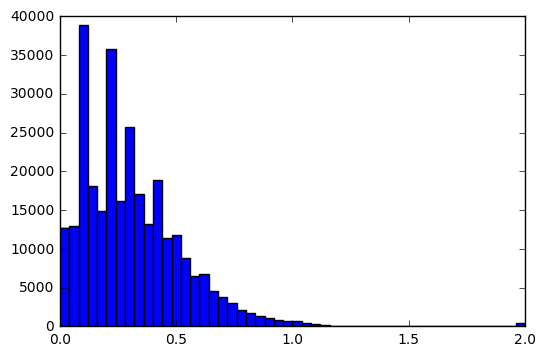

In [9]:
plt.hist(valid_gamma, 50);
plt.xlim([0,2])

In [10]:
np.sum(valid_gamma <= 1) / len(valid_gamma)

0.99120533234586183

In [11]:
relevant_slice = (
    np.max(dose_evaluation, axis=(0, 1)) > 
    lower_dose_cutoff)
slice_start = np.max([
        np.where(relevant_slice)[0][0], 
        0])
slice_end = np.min([
        np.where(relevant_slice)[0][-1], 
        len(z_evaluation)])

C:\Users\RCole02.ROYALSURREY\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in greater


Slice = -67.5


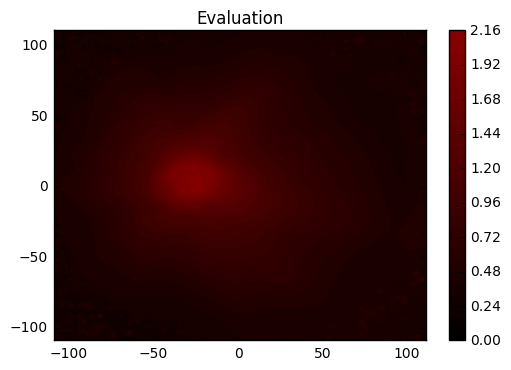

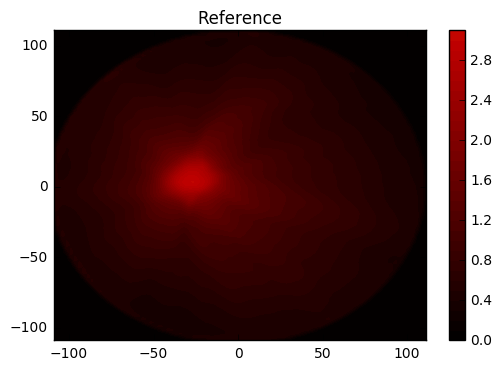

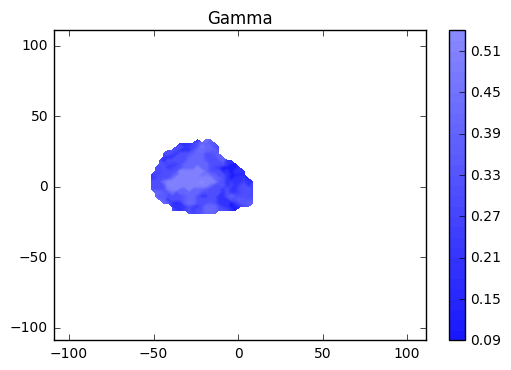



Slice = -55.0


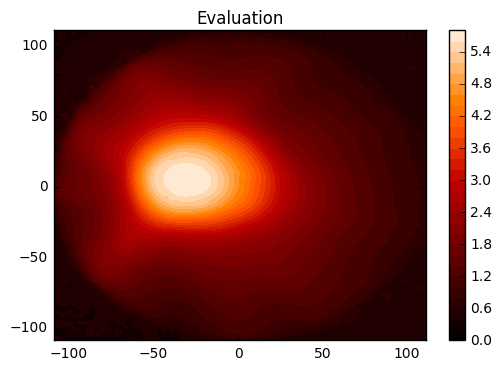

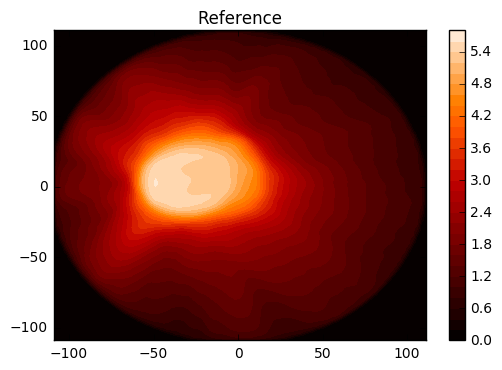

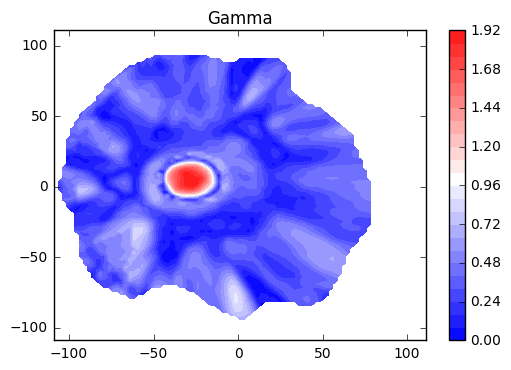



Slice = -42.5


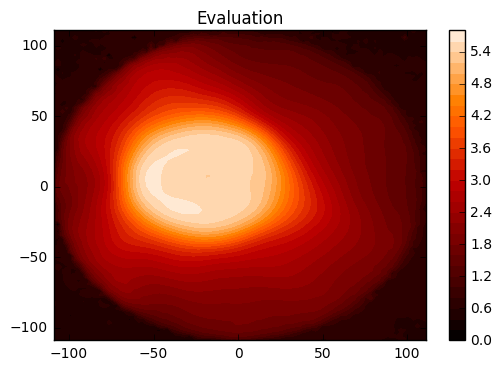

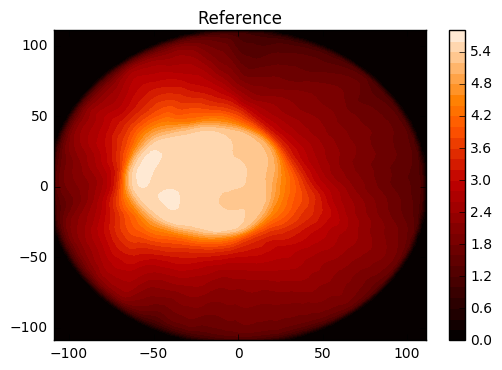

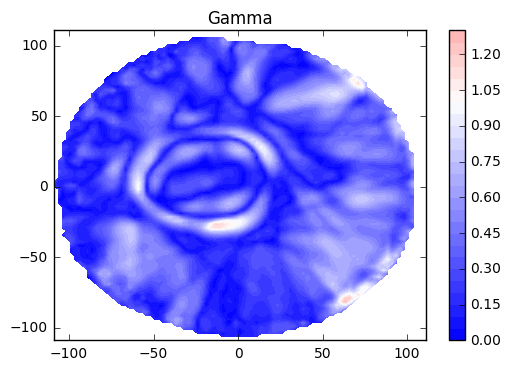



Slice = -30.0


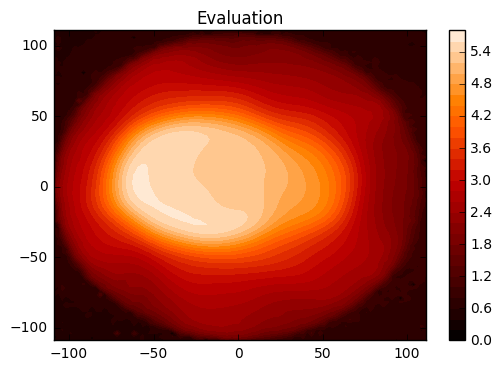

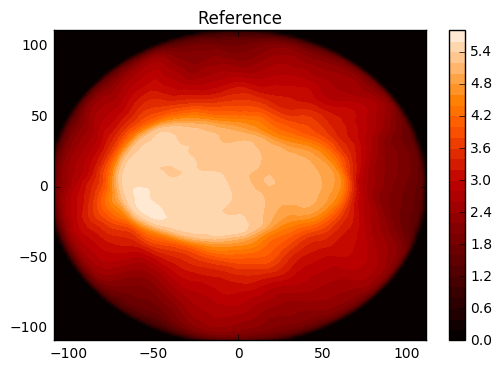

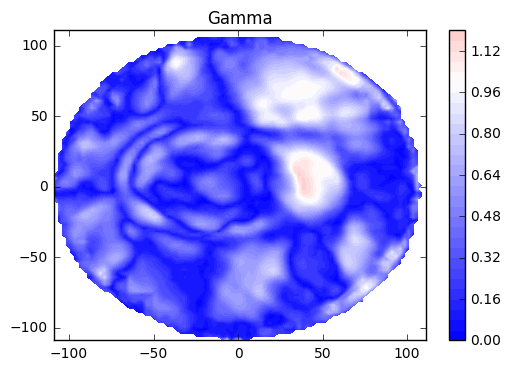



Slice = -17.5


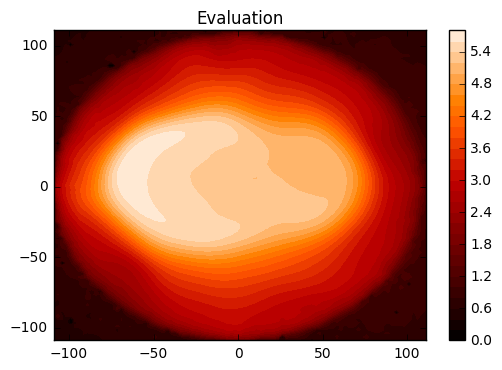

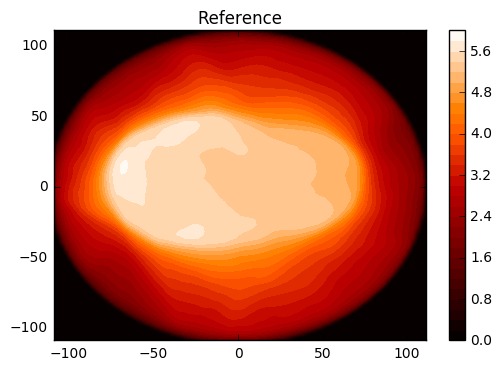

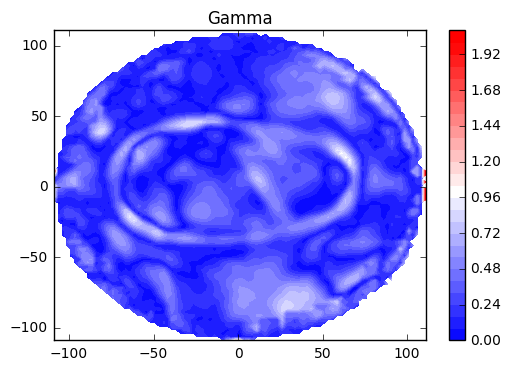



Slice = -5.0


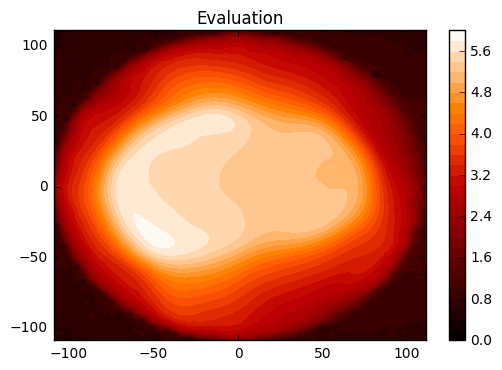

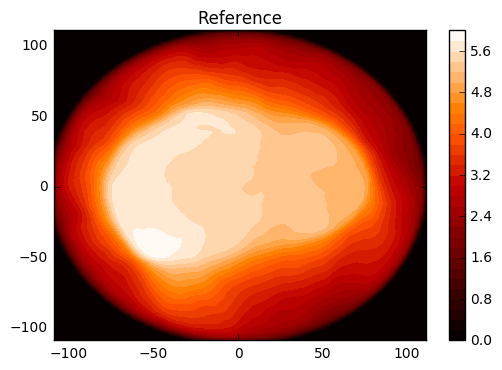

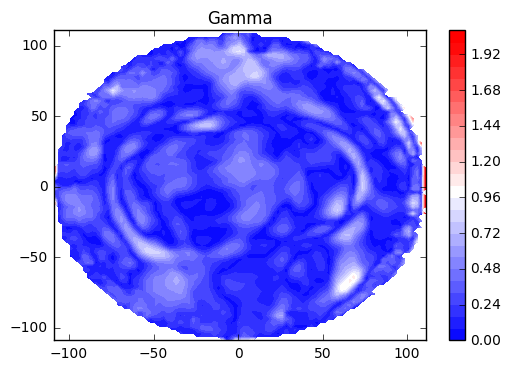



Slice = 7.5


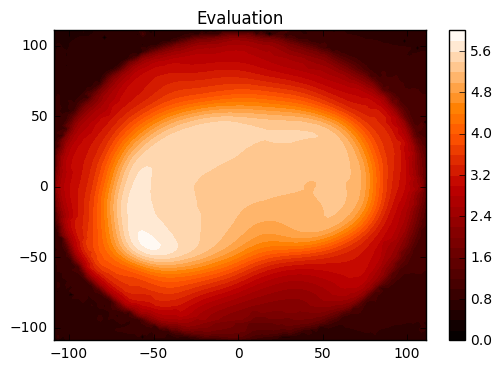

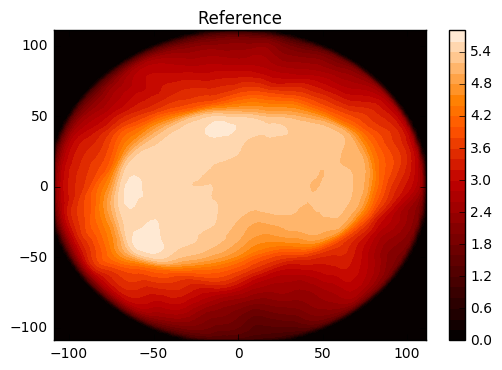

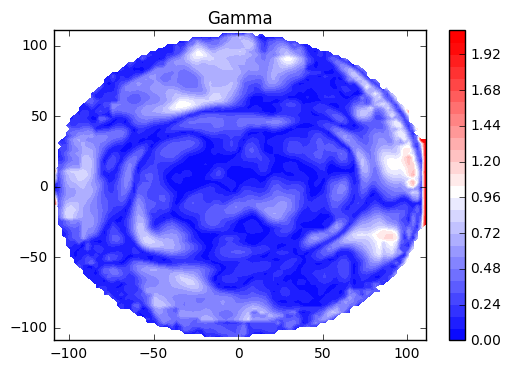



Slice = 20.0


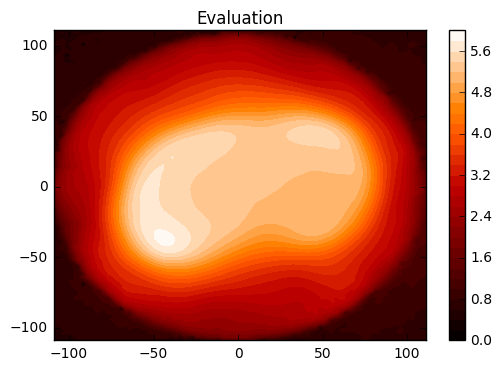

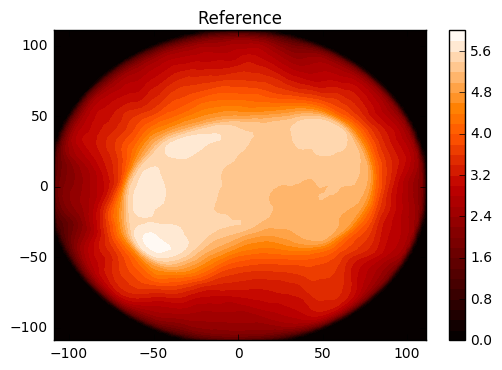

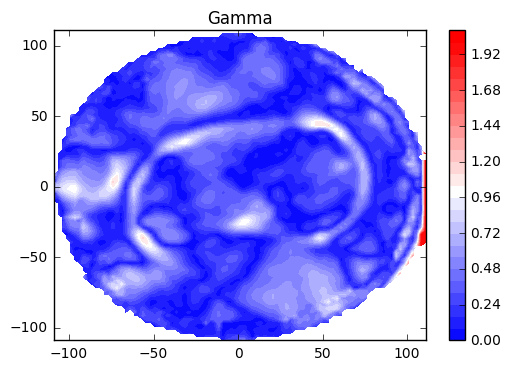



Slice = 32.5


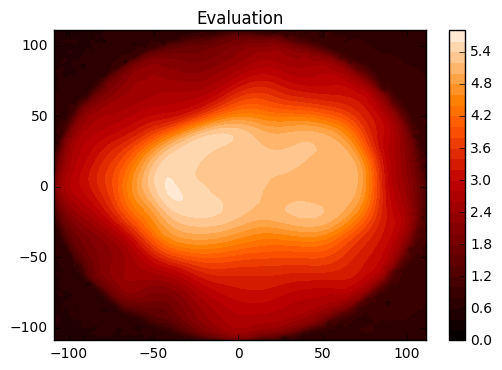

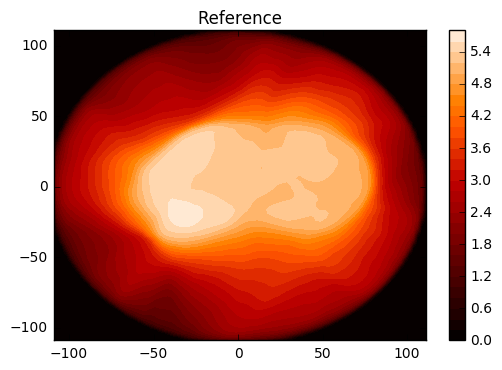

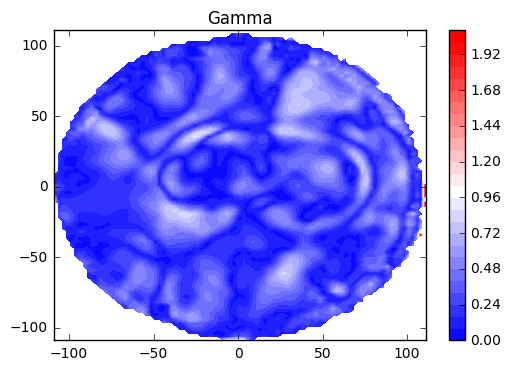



Slice = 45.0


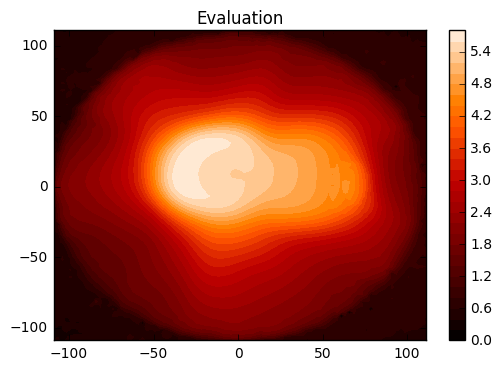

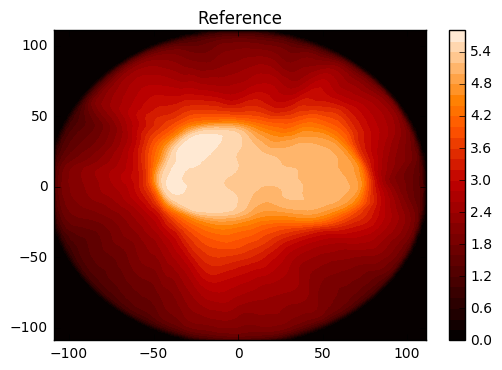

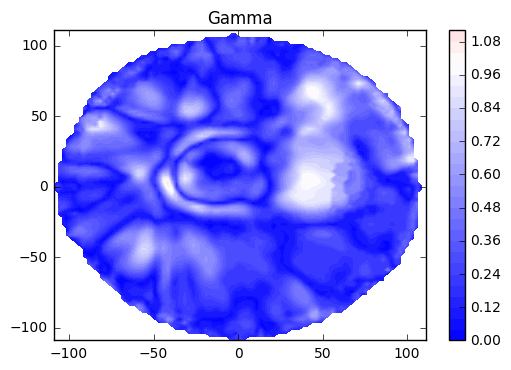



Slice = 57.5


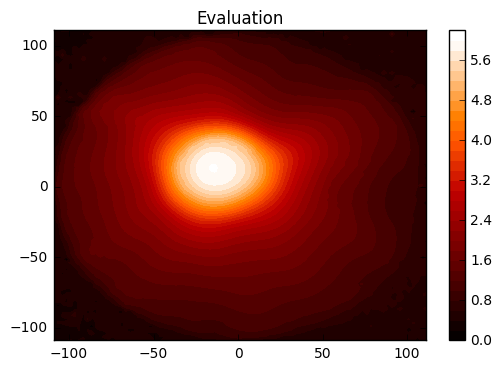

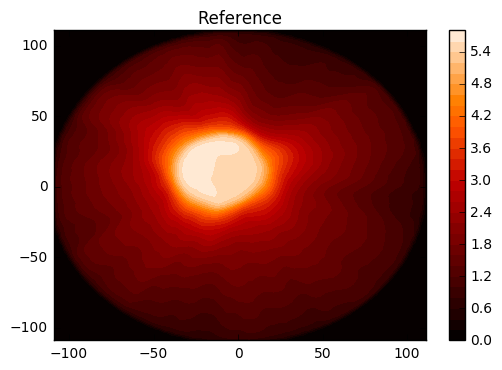

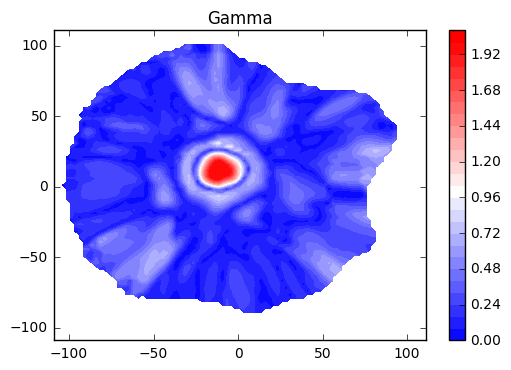



Slice = 70.0


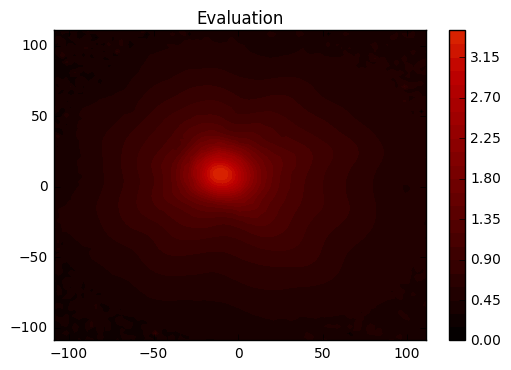

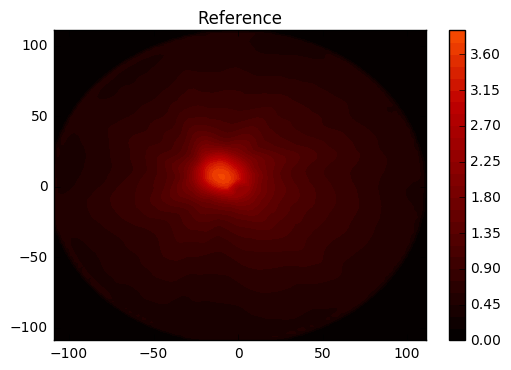

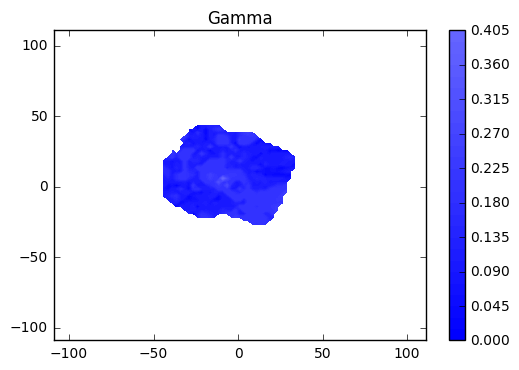

In [12]:
max_ref_dose = np.max(dose_reference)

cut_off_gamma = gamma.copy()
greater_than_2_ref = (cut_off_gamma > 2) & ~np.isinf(gamma)
cut_off_gamma[greater_than_2_ref] = 2

for z_i in z_evaluation[slice_start:slice_end:5]:
    i = np.where(z_i == z_evaluation)[0][0]
    j = np.where(z_i == z_reference)[0][0]
    print("======================================================================")
    print("Slice = {0}".format(z_i))  
   
    plt.contourf(
        x_evaluation, y_evaluation, dose_evaluation[:, :, j], 30, 
        vmin=0, vmax=max_ref_dose, cmap=plt.get_cmap('gist_heat'))
    plt.title("Evaluation")
    plt.colorbar()
    plt.show()
    
    plt.contourf(
        x_reference, y_reference, dose_reference[:, :, j], 30, 
        vmin=0, vmax=max_ref_dose, cmap=plt.get_cmap('gist_heat'))
    plt.title("Reference")  
    plt.colorbar()
    plt.show()
    
    plt.contourf(
        x_evaluation, y_evaluation, cut_off_gamma[:, :, i], 30, 
        vmin=0, vmax=2, cmap=plt.get_cmap('bwr'))
    plt.title("Gamma")    
    plt.colorbar()  
    plt.show()
    
    print("\n")